In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2 Pred", "R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
104865,37149,0,24,90,0.0,93.0,16.100334,9.0,18.676886,0.0,...,0,0,0,0,0,0,1,0,0,0
157374,98168,0,1843,36,0.0,394.0,32.696707,21.0,41.200232,0.0,...,0,0,0,0,0,0,1,0,0,5
145119,8070687,421,278406,9,0.0,1683.0,395.721060,264.0,357.056684,0.0,...,0,0,0,0,1,0,0,0,0,6
143403,4913787,60,158828,9,0.0,1485.0,159.488910,108.0,183.908018,0.0,...,0,1,0,0,1,0,0,0,0,0
171956,22665,0,15605,92,0.0,251.0,47.831340,36.0,44.013064,0.0,...,1,0,0,0,0,0,0,0,1,7
76534,3378,0,50,8,0.0,32.0,4.509804,1.0,7.154794,0.0,...,0,1,0,0,1,0,0,0,0,0
37174,23985,178,2773,36,0.0,184.0,17.119349,11.0,21.469568,0.0,...,0,0,0,0,1,0,0,0,0,0
113441,1204214,0,6418,1,0.0,105.0,5.699214,3.0,10.894731,0.0,...,0,1,0,0,1,0,0,0,0,0
57707,12683158,0,615045,4,313.0,1295.0,771.480000,679.0,269.401874,12.0,...,1,0,0,0,0,0,0,1,0,226
31925,1422427,0,35610,9,0.0,214.0,34.748307,19.0,40.813882,0.0,...,0,0,0,0,0,0,0,1,0,0


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
# base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
#                           + training_dataset["Base DateTime weekday-Tuesday"]
#                           + training_dataset["Base DateTime weekday-Wednesday"]
#                           + training_dataset["Base DateTime weekday-Thursday"]
#                           + training_dataset["Base DateTime weekday-Friday"]).astype("int")
# base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
#                           + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
# training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
# training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
# training_dataset.drop(
#     ["Base DateTime weekday-Saturday",
#      "Base DateTime weekday-Sunday",
#      "Base DateTime weekday-Monday",
#      "Base DateTime weekday-Tuesday",
#      "Base DateTime weekday-Wednesday",
#      "Base DateTime weekday-Thursday",
#      "Base DateTime weekday-Friday"], axis = 1, inplace = True)
# training_dataset

In [7]:
features = training_dataset.iloc[:, :43]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,CC5,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,25,166,2,0,24,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,70,132,1,0,24,1,0,1,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,26,133,2,0,24,1,0,0,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,67,131,1,0,24,1,0,0,1
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,65,142,5,0,24,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1940,16,77,2123,0,24,1,0,0,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,155,4,130,474,0,24,1,0,0,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,207,12,12,1511,0,24,1,0,0,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,-459,31,149,1099,0,24,1,0,0,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# LightGBM

## Model Training

In [10]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    predict = model.predict(X_test)
    return predict

In [11]:
def plot_test_predict(y_train, y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [12]:
def evaluate(model, X_test, y_test, predict):

    # R-Squared Prediction
    r2_pred = model.score(X_test, y_test)
    
    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [13]:
def train_final_model(max_depth=None, n_estimators=100):
    # LGBMRegressor
    model = LGBMRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )

    # Model Training
    predict = train_model(model)
    plot_test_predict(y_train, y_test, predict)

    # Model Evaluation
    r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, X_test, y_test, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

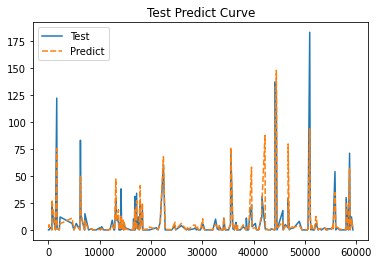

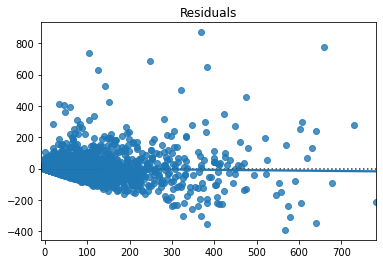

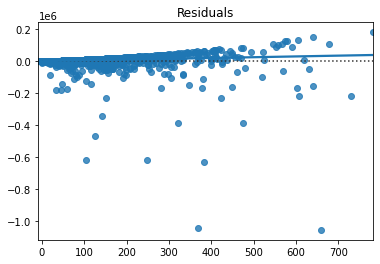

       Index        Mean
0    R2 Pred    0.743288
1         R2    0.743288
2         EV    0.743302
3         ME  866.050275
4    MEAN_AE    3.591154
5        MSE  263.417320
6  MEDIAN_AE    0.541830
7     HIT@10    0.931903
8    HIT@100    0.580000


In [14]:
train_final_model(max_depth=12, n_estimators=60)